In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.preprocessing import LabelEncoder
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [2]:
df = pd.read_csv(r"C:\Users\user\Desktop\completeSpamAssassin.csv")

In [3]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [5]:
df = df.drop_duplicates(keep='first')

In [6]:
df.duplicated().sum()

0

In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(6045, 3)

In [9]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [10]:
df['Label'].value_counts()

Label
0    4150
1    1895
Name: count, dtype: int64

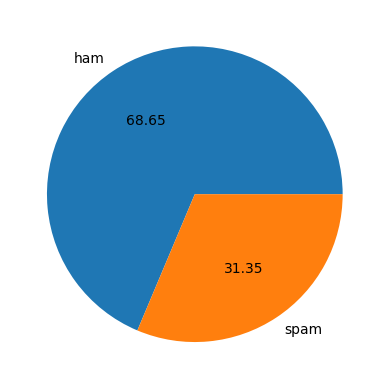

In [11]:
plt.pie(df['Label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
print(df.columns)

Index(['Body', 'Label'], dtype='object')


In [15]:
ps = PorterStemmer()

In [16]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [17]:
df['transformed_body'] = df['Body'].apply(transform_text)

In [18]:
texts = df["transformed_body"].tolist()

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='pre')


In [20]:
len(tokenizer.word_index)

36934

In [21]:
padded_sequences.shape

(6045, 9015)

In [40]:
model = Sequential()
model.add(Embedding(36935, 10, input_length=max_length))
model.add(LSTM(10))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 9015, 10)          369350    
                                                                 
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 dense_8 (Dense)             (None, 20)                220       
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 370431 (1.41 MB)
Trainable params: 370431 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.fit(padded_sequences,df["Label"],epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
152/152 [==============================] - 431s 3s/step - loss: 0.6749 - accuracy: 0.6032 - val_loss: 0.4997 - val_accuracy: 1.0000
Epoch 2/5
152/152 [==============================] - 431s 3s/step - loss: 0.6700 - accuracy: 0.6081 - val_loss: 0.4951 - val_accuracy: 1.0000
Epoch 3/5
152/152 [==============================] - 429s 3s/step - loss: 0.6703 - accuracy: 0.6081 - val_loss: 0.4718 - val_accuracy: 1.0000
Epoch 4/5
152/152 [==============================] - 431s 3s/step - loss: 0.6703 - accuracy: 0.6081 - val_loss: 0.4936 - val_accuracy: 1.0000
Epoch 5/5
152/152 [==============================] - 434s 3s/step - loss: 0.6702 - accuracy: 0.6081 - val_loss: 0.4988 - val_accuracy: 1.0000


In [56]:
lmodel = Sequential()
lmodel.add(Embedding(36935, 10, input_length=max_length))
lmodel.add(Bidirectional(LSTM(10)))
lmodel.add(Dense(20, activation='relu'))
lmodel.add(Dense(1, activation='sigmoid'))


In [57]:
lmodel.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [58]:
lmodel.fit(padded_sequences,df["Label"],epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
152/152 [==============================] - 547s 4s/step - loss: 0.4668 - accuracy: 0.7758 - val_loss: 0.4037 - val_accuracy: 0.7800
Epoch 2/5
152/152 [==============================] - 531s 3s/step - loss: 0.1322 - accuracy: 0.9667 - val_loss: 0.4614 - val_accuracy: 0.7858
Epoch 3/5
152/152 [==============================] - 535s 4s/step - loss: 0.0869 - accuracy: 0.9748 - val_loss: 0.4843 - val_accuracy: 0.7792
Epoch 4/5
152/152 [==============================] - 537s 4s/step - loss: 0.0693 - accuracy: 0.9773 - val_loss: 0.4925 - val_accuracy: 0.7767
Epoch 5/5
152/152 [==============================] - 542s 4s/step - loss: 0.0612 - accuracy: 0.9777 - val_loss: 0.5631 - val_accuracy: 0.7610


In [60]:
l1model = Sequential()
l1model.add(Embedding(36935, 10, input_length=max_length))
l1model.add(Bidirectional(LSTM(10)))
l1model.add(Dropout(0.3))
l1model.add(Dense(20, activation='relu'))
l1model.add(Dropout(0.3))
l1model.add(Dense(1, activation='sigmoid'))


In [61]:
l1model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [64]:
log_dir = "logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [65]:
l1model.fit(padded_sequences,df["Label"],epochs=5, validation_split=0.2, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/5
152/152 [==============================] - 595s 4s/step - loss: 0.5282 - accuracy: 0.7186 - val_loss: 0.2041 - val_accuracy: 0.8528
Epoch 2/5
152/152 [==============================] - 596s 4s/step - loss: 0.1617 - accuracy: 0.9605 - val_loss: 0.4653 - val_accuracy: 0.7957
Epoch 3/5
152/152 [==============================] - 603s 4s/step - loss: 0.0995 - accuracy: 0.9729 - val_loss: 0.4123 - val_accuracy: 0.8230
Epoch 4/5
152/152 [==============================] - 556s 4s/step - loss: 0.0864 - accuracy: 0.9733 - val_loss: 0.6165 - val_accuracy: 0.7725
Epoch 5/5
152/152 [==============================] - 541s 4s/step - loss: 0.0729 - accuracy: 0.9739 - val_loss: 0.5315 - val_accuracy: 0.8056


In [66]:
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [67]:
pickle.dump(model,open('lstmmodel.pkl','wb'))

In [68]:
pickle.dump(l1model,open('bilstmmodel.pkl','wb'))